In [1]:
import initialize
settings = initialize.Settings()
# Generate plot of raw data and ask if ready to start processing =========
try:
    print('Probing data "%s"...' % settings.fileName)
    # settings.probeData()
    # settings.probeData('C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin')
finally:
    pass
print('  Raw IF data plotted ')
print('  (run setSettings or change settings in "initialize.py" to reconfigure)')
print(' ')
gnssStart = True

Probing data "C:/Repository/SoftGNSS-python/GNSS_signal_records/GPSdata-DiscreteComponents-fs38_192-if9_55.bin"...
  Raw IF data plotted 
  (run setSettings or change settings in "initialize.py" to reconfigure)
 


In [2]:
import matplotlib.pyplot as plt # type: ignore
from scipy.signal import welch # type: ignore
from scipy.signal.windows import hamming # type: ignore
import datetime
import numpy as np # type: ignore
fileNameStr='C:\Repository\Scripts_general\SoftGNSS-python\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'

# Check the number of arguments ==========================================
if fileNameStr is None:
    # fileNameStr = self.fileName
    if not isinstance(fileNameStr, str):
         raise TypeError('File name must be a string')


In [3]:
# Processing settings ====================================================
# Number of milliseconds to be processed used 36000 + any transients 
# (see # below - in Nav parameters) to ensure nav subframes are provided
settings.msToProcess = 37000.0
# Number of channels to be used for signal processing
settings.numberOfChannels = 8
# # Move the starting point of processing. Can be used to start the signal
# # processing at any point in the data record (e.g. for long records). 
# fseek function is used to move the file read point, therefore advance is byte based only.
settings.skipNumberOfBytes = 0
# Raw signal file name and other parameter ===============================
# This is a "default" name of the data file (signal record) to be used in
# the post-processing mode
settings.fileName = 'C:\Repository\Scripts_general\SoftGNSS-python\GNSS_signal_records\GPSdata-DiscreteComponents-fs38_192-if9_55.bin'
# Data type used to store one sample
settings.dataType = 'int8'
# Intermediate, sampling and code frequencies
settings.IF = 9548000.0
settings.samplingFreq = 38192000.0
settings.codeFreqBasis = 1023000.0
# Define number of chips in a code period
settings.codeLength = 1023
# Acquisition settings ===================================================
# Skips acquisition in the script postProcessing.m if set to 1
settings.skipAcquisition = False
# List of satellites to look for. Some satellites can be excluded to speed
# up acquisition
settings.acqSatelliteList = range(1, 33)
# Band around IF to search for satellite signal. Depends on max Doppler
settings.acqSearchBand = 14.0
# Threshold for the signal presence decision rule
settings.acqThreshold = 2.5
# Tracking loops settings ================================================
# Code tracking loop parameters
settings.dllDampingRatio = 0.7
settings.dllNoiseBandwidth = 2.0
settings.dllCorrelatorSpacing = 0.5
# Carrier tracking loop parameters
settings.pllDampingRatio = 0.7
settings.pllNoiseBandwidth = 25.0
# Navigation solution settings ===========================================
# Period for calculating pseudoranges and position
settings.navSolPeriod = 500.0
# Elevation mask to exclude signals from satellites at low elevation
settings.elevationMask = 10.0
# # Enable/dissable use of tropospheric correction
settings.useTropCorr = True
# 1 - On
# True position of the antenna in UTM system (if known). Otherwise enter
# all NaN's and mean position will be used as a reference .
# settings.truePosition = TruePosition()
# settings.truePosition.E = np.nan
# settings.truePosition.N = np.nan
# settings.truePosition.U = np.nan
# # Plot settings ==========================================================
# # Enable/disable plotting of the tracking results for each channel
settings.plotTracking = True
# 1 - On
# Constants ==============================================================
settings._c = 299792458.0
settings._startOffset = 68.802

In [4]:
try:
        with open(fileNameStr, 'rb') as fid:
                fid.seek(settings.skipNumberOfBytes, 0)
                samplesPerCode = settings.samplesPerCode
                try:
                        data = np.fromfile(fid, settings.dataType, 10 * samplesPerCode)
                except IOError:
                    # The file is too short
                    print('Could not read enough data from the data file.')
except IOError as e:
        print('Unable to read file "%s": %s' % (fileNameStr, e))

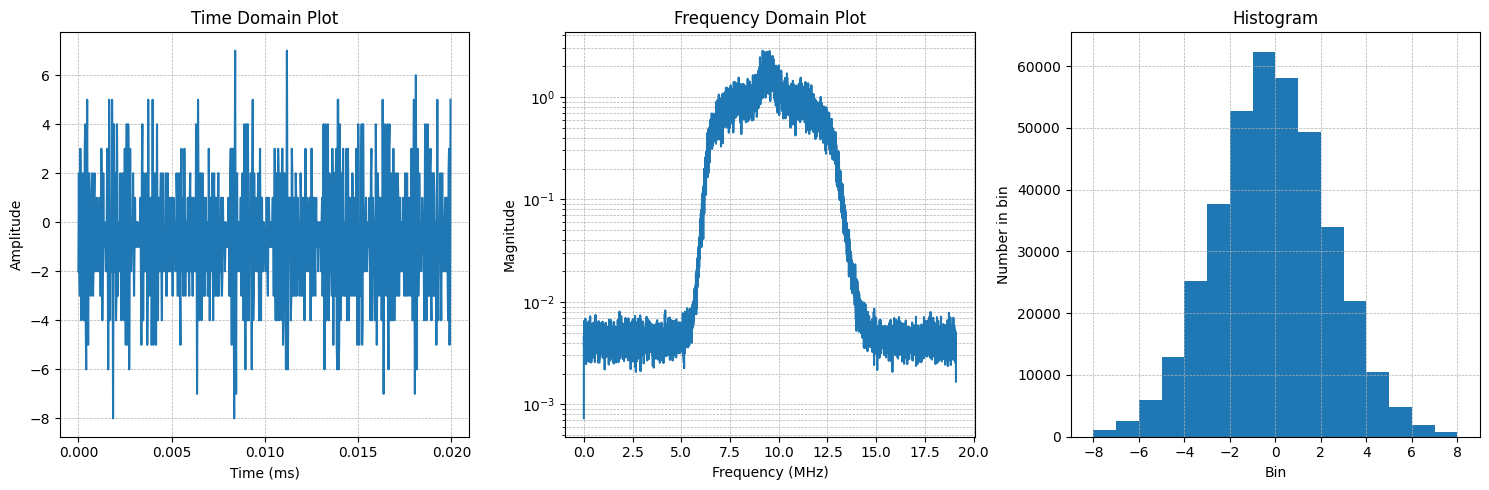

In [5]:
timeScale = np.arange(0, 0.05, 1 / settings.samplingFreq) # type: ignore

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primeiro subplot: Domínio do Tempo
axs[0].plot(1000 * timeScale[:int(samplesPerCode / 50)], data[:int(samplesPerCode / 50)])
axs[0].set_title('Time Domain Plot')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Amplitude')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}'))
axs[0].set_xticks(np.arange(0, 0.025, 0.005)) # type: ignore

# Segundo subplot: Domínio da Frequência
f, Pxx = welch(data - np.mean(data), settings.samplingFreq / 1e6, hamming(16384, False), 16384, 1024, 16384) # type: ignore
axs[1].semilogy(f, Pxx)
axs[1].set_title('Frequency Domain Plot')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Magnitude')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Terceiro subplot: Histograma
dmax = np.max(np.abs(data)) + 1 # type: ignore
axs[2].hist(data, bins=np.arange(-128, 128))
axs[2].set_title('Histogram')
axs[2].set_xlabel('Bin')
axs[2].set_ylabel('Number in bin')
axs[2].set_xlim([-dmax, dmax])
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)

# Ajustar layout
plt.tight_layout()
plt.show()

In [6]:
import acquisition
import postNavigation
import tracking
print('Starting processing...')


Importing functions from ./geoFunctions/
Starting processing...


In [7]:
if not fileNameStr:
    fileNameStr = settings.fileName
if not isinstance(fileNameStr, str):
    raise TypeError('File name must be a string')

In [8]:
with open(fileNameStr, 'rb') as fid:
    fid.seek(settings.skipNumberOfBytes, 0)
    if not settings.skipAcquisition:  # or 'acqResults' not in globals():
    # Find number of samples per spreading code
        samplesPerCode = settings.samplesPerCode
        # frequency estimation
        data = np.fromfile(fid, settings.dataType, 11 * samplesPerCode) # type: ignore

In [9]:
# Performs cold start acquisition on the collected "data". 
# It searches for GPS signals of all satellites, which are listed in field
# "acqSatelliteList" in the settings structure. Function saves code phase
# and frequency of the detected signals in the "acqResults" structure.
# acqResults = acquisition(longSignal, settings)
# Inputs =========================================================
# longSignal    - 11 ms of raw signal from the front-end
# settings      - Receiver settings. Provides information about
# sampling and intermediate frequencies and other
# parameters including the list of the satellites to be acquired.
# Outputs =========================================================
# acqResults    - Function saves code phases and frequencies of the
# detected signals in the "acqResults" structure. The
# field "carrFreq" is set to 0 if the signal is not detected for the given PRN number.
# Initialization =========================================================
# settings = self._settings
# Find number of samples per spreading code
samplesPerCode = settings.samplesPerCode
longSignal = data
# Create two 1m sec vectors of data to correlate with and one with zero DC
signal1 = longSignal[0:samplesPerCode]
signal2 = longSignal[samplesPerCode:2 * samplesPerCode]
signal0DC = longSignal - longSignal.mean()
# Find sampling period
ts = 1.0 / settings.samplingFreq
# Find phase points of the local carrier wave
phasePoints = np.arange(samplesPerCode) * 2 * np.pi * ts
# Number of the frequency bins for the given acquisition band (500Hz steps)
numberOfFrqBins = np.int64(np.round(settings.acqSearchBand * 2) + 1)
# Generate all C/A codes and sample them according to the sampling freq.
caCodesTable = settings.makeCaTable()
# --- Initialize arrays to speed up the code -------------------------------
# Search results of all frequency bins and code shifts (for one satellite)
results = np.zeros((numberOfFrqBins, samplesPerCode))
# Carrier frequencies of the frequency bins
frqBins = np.zeros(numberOfFrqBins)
# --- Initialize acqResults ------------------------------------------------
# Carrier frequencies of detected signals
carrFreq = np.zeros(32)
# C/A code phases of detected signals
codePhase_ = np.zeros(32)
# Correlation peak ratios of the detected signals
peakMetric = np.zeros(32)

In [10]:
print(' Perform search for all listed PRN numbers ...')
for PRN in range(len(settings.acqSatelliteList)):
    # Correlate signals ======================================================
    # --- Perform DFT of C/A code ------------------------------------------
    caCodeFreqDom = np.fft.fft(caCodesTable[PRN, :]).conj()
    for frqBinIndex in range(numberOfFrqBins):
        # --- Generate carrier wave frequency grid (0.5kHz step) -----------
        frqBins[frqBinIndex] = settings.IF - settings.acqSearchBand / 2 * 1000 + 500.0 * frqBinIndex
        sinCarr = np.sin(frqBins[frqBinIndex] * phasePoints)
        cosCarr = np.cos(frqBins[frqBinIndex] * phasePoints)
        I1 = sinCarr * signal1
        Q1 = cosCarr * signal1
        I2 = sinCarr * signal2
        Q2 = cosCarr * signal2
        IQfreqDom1 = np.fft.fft(I1 + 1j * Q1)
        IQfreqDom2 = np.fft.fft(I2 + 1j * Q2)
        # domain
        convCodeIQ1 = IQfreqDom1 * caCodeFreqDom
        convCodeIQ2 = IQfreqDom2 * caCodeFreqDom
        acqRes1 = abs(np.fft.ifft(convCodeIQ1)) ** 2
        acqRes2 = abs(np.fft.ifft(convCodeIQ2)) ** 2

        # "blend" 1st and 2nd msec but will correct data bit issues
        if acqRes1.max() > acqRes2.max():
            results[frqBinIndex, :] = acqRes1
        else:
            results[frqBinIndex, :] = acqRes2

    # Look for correlation peaks in the results ==============================
    # Find the highest peak and compare it to the second highest peak
    # The second peak is chosen not closer than 1 chip to the highest peak
    # --- Find the correlation peak and the carrier frequency --------------
    peakSize = results.max(1).max()
    frequencyBinIndex = results.max(1).argmax()
    peakSize = results.max(0).max()
    codePhase = results.max(0).argmax()
    samplesPerCodeChip = np.int64(round(settings.samplingFreq / settings.codeFreqBasis))
    excludeRangeIndex1 = codePhase - samplesPerCodeChip
    excludeRangeIndex2 = codePhase + samplesPerCodeChip
    # boundaries
    if excludeRangeIndex1 <= 0:
        codePhaseRange = np.r_[excludeRangeIndex2:samplesPerCode + excludeRangeIndex1 + 1]
    elif excludeRangeIndex2 >= samplesPerCode - 1:
        codePhaseRange = np.r_[excludeRangeIndex2 - samplesPerCode:excludeRangeIndex1]
    else:
        codePhaseRange = np.r_[0:excludeRangeIndex1 + 1, excludeRangeIndex2:samplesPerCode]
    # --- Find the second highest correlation peak in the same freq. bin ---
    secondPeakSize = results[frequencyBinIndex, codePhaseRange].max()
    peakMetric[PRN] = peakSize / secondPeakSize

    if (peakSize / secondPeakSize) > settings.acqThreshold:
    # Fine resolution frequency search =======================================
    # --- Indicate PRN number of the detected signal -------------------
        print('%02d' % (PRN + 1), end=' ')  # Saída na mesma linha
        caCode = settings.generateCAcode(PRN)
        codeValueIndex = np.floor(ts * np.arange(1, 10 * samplesPerCode + 1) / (1.0 / settings.codeFreqBasis))
        longCaCode = caCode[np.longlong(codeValueIndex % 1023)]
        # (Using detected C/A code phase)
        xCarrier = signal0DC[codePhase:codePhase + 10 * samplesPerCode] * longCaCode
        fftNumPts = 8 * 2 ** (np.ceil(np.log2(len(xCarrier))))
        # associated carrier frequency
        fftxc = np.abs(np.fft.fft(xCarrier, np.int64(fftNumPts)))
        uniqFftPts = np.int64(np.ceil((fftNumPts + 1) / 2.0))
        fftMax = fftxc[4:uniqFftPts - 5].max()
        fftMaxIndex = fftxc[4:uniqFftPts - 5].argmax()
        fftFreqBins = np.arange(uniqFftPts) * settings.samplingFreq / fftNumPts
        carrFreq[PRN] = fftFreqBins[fftMaxIndex]
        codePhase_[PRN] = codePhase
    else:
        # --- No signal with this PRN --------------------------------------
        print('. ', end=' ')  # Saída na mesma linha para os que falharam
# === Acquisition is over ==================================================
acqResults = np.core.records.fromarrays([carrFreq, codePhase_, peakMetric], names='carrFreq,codePhase,peakMetric')
acqResults._results = acqResults

 Perform search for all listed PRN numbers ...
.  .  03 .  .  06 .  .  09 .  .  .  .  .  15 .  .  18 .  .  21 22 .  .  .  26 .  .  .  .  .  .  

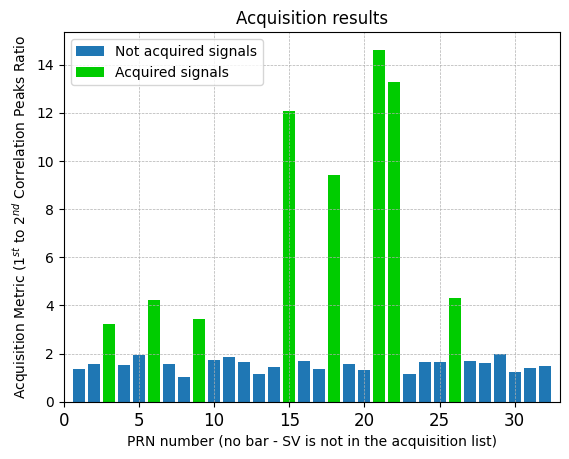

In [11]:
assert isinstance(acqResults._results, np.recarray)
import matplotlib as mpl # type: ignore
import matplotlib.pyplot as plt # type: ignore

# Plot all results =======================================================
f, hAxes = plt.subplots()

# Plot barra para peakMetric
plt.bar(range(1, 33), acqResults.peakMetric)
plt.title('Acquisition results')
plt.xlabel('PRN number (no bar - SV is not in the acquisition list)')
plt.ylabel('Acquisition Metric ($1^{st}$ to $2^{nd}$ Correlation Peaks Ratio')

oldAxis = plt.axis()
plt.axis([0, 33, 0, oldAxis[-1]])
plt.xticks(range(1, 33), size=12)

# Mark acquired signals ==================================================
acquiredSignals = acqResults.peakMetric * (acqResults.carrFreq > 0)

# Alterar ticks do eixo X corretamente
hAxes.set_xticks(np.arange(0, 33, 5))  # Modifiquei para hAxes.set_xticks() que é o correto

# Plot barra para sinais adquiridos
plt.bar(range(1, 33), acquiredSignals, color=(0, 0.8, 0))

# Adicionar legenda
plt.legend(['Not acquired signals', 'Acquired signals'])

# Adicionar grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()


In [12]:
if np.any(acqResults.carrFreq): # type: ignore
    assert isinstance(acqResults._results, np.recarray)
    # Initializes tracking channels from acquisition data. The acquired
    # signals are sorted according to the signal strength. This function can be
    # modified to use other satellite selection algorithms or to introduce
    # acquired signal properties offsets for testing purposes.
    # Inputs ================================================
    # acqResults  - results from acquisition.
    # settings    - receiver settings
    # Outputs ================================================
    # channel     - structure contains information for each channel (like
    # properties of the tracked signal, channel status etc.).
    # Initialize all channels ================================================
    PRN = np.zeros(settings.numberOfChannels, dtype='int64')
    acquiredFreq = np.zeros(settings.numberOfChannels)
    codePhase = np.zeros(settings.numberOfChannels)
    status = ['-' for _ in range(settings.numberOfChannels)]
    # --- Copy initial data to all channels ------------------------------------
    # Copy acquisition results ===============================================
    # --- Sort peaks to find strongest signals, keep the peak index information
    PRNindexes = sorted(enumerate(acqResults.peakMetric), key=lambda x: x[-1], reverse=True)
    # --- Load information about each satellite --------------------------------
    # Maximum number of initialized channels is number of detected signals, but
    # not more as the number of channels specified in the settings.
    for ii in range(min(settings.numberOfChannels, sum(acqResults.carrFreq > 0))):
        PRN[ii] = PRNindexes[ii][0] + 1
        acquiredFreq[ii] = acqResults.carrFreq[PRNindexes[ii][0]]
        codePhase[ii] = acqResults.codePhase[PRNindexes[ii][0]]
        status[ii] = 'T'
    channel = np.core.records.fromarrays([PRN, acquiredFreq, codePhase, status],
                                     names='PRN,acquiredFreq,codePhase,status')
    acqResults._channels = channel
    # Prints the status of all channels in a table.
    # Inputs ================================================
    # channel - data for each channel. It is used to initialize and
    # at the processing of the signal (tracking part).
    # settings    - receiver settings
    channel = acqResults._channels
    # settings = self._settings
    assert isinstance(channel, np.recarray)
    print ('\n*=========*=====*===============*===========*=============*========*')
    print ('| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |')
    print ('*=========*=====*===============*===========*=============*========*')
    for channelNr in range(settings.numberOfChannels):
        if channel[channelNr].status != '-':
            print('|      %2d | %3d |  %2.5e |   %5.0f   |    %6d   |     %1s  |' % (channelNr,channel[channelNr].PRN,channel[channelNr].acquiredFreq,channel[channelNr].acquiredFreq - settings.IF,channel[channelNr].codePhase,channel[channelNr].status))
        else:
            print('|      %2d | --- |  ------------ |   -----   |    ------   |   Off  |' % channelNr)
    print('*=========*=====*===============*===========*=============*========*\n')
else:
    # No satellites to track, exit
    print('No GNSS signals detected, signal processing finished.')
    trackResults = None



*=========*=====*===============*===========*=============*========*
| Channel | PRN |   Frequency   |  Doppler  | Code Offset | Status |
*=========*=====*===============*===========*=============*========*
|       0 |  21 |  9.54743e+06 |    -574   |     13403   |     T  |
|       1 |  22 |  9.54969e+06 |    1694   |      6287   |     T  |
|       2 |  15 |  9.54992e+06 |    1921   |     36320   |     T  |
|       3 |  18 |  9.54825e+06 |     246   |     20723   |     T  |
|       4 |  26 |  9.54501e+06 |   -2987   |     26826   |     T  |
|       5 |   6 |  9.54431e+06 |   -3688   |     28201   |     T  |
|       6 |   9 |  9.55083e+06 |    2832   |      4695   |     T  |
|       7 |   3 |  9.54990e+06 |    1903   |     34211   |     T  |
*=========*=====*===============*===========*=============*========*



In [13]:
# Track the signal =======================================================
startTime = datetime.datetime.now()
print('   Tracking started at %s' % startTime.strftime('%X'))
acqResults.channels = channel
acqResults.settings = settings
trackResults = tracking.TrackingResult(acqResults)
try:
    trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)
except IOError:
    trackResults.track(fid)
    np.save('trackingResults_python', trackResults.results)

print('   Tracking is over (elapsed time %s s)' % (datetime.datetime.now() - startTime).total_seconds())
print('   Saving Acquisition & Tracking results to storage')
# Calculate navigation solutions =========================================
print('   Calculating navigation solutions...')

   Tracking started at 09:17:21
   Tracking is over (elapsed time 0.034272 s)
   Saving Acquisition & Tracking results to storage
   Calculating navigation solutions...


In [14]:
import matplotlib as mpl # type: ignore
import matplotlib.gridspec as gs # type: ignore
import matplotlib.pyplot as plt # type: ignore
# # %% configure matplotlib
# mpl.rcdefaults()
# mpl.rcParams['font.sans-serif']
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', bbox='tight', transparent=False, format='png')
# mpl.rc('axes', grid=True, linewidth=1.5, axisbelow=True)
# mpl.rc('lines', linewidth=1.5, solid_joinstyle='bevel')
# mpl.rc('figure', figsize=[8, 6], dpi=120)
# mpl.rc('text', usetex=True)
# mpl.rc('font', family='serif', serif='Computer Modern Roman', size=8)
# mpl.rc('mathtext', fontset='cm')
# mpl.rc('font', size=16)
# mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')
# ./plotTracking.m
# trackResults = trackResults._results
# settings = trackResults._settings
channelList = range(settings.numberOfChannels)
# %% configure matplotlib
# mpl.rcdefaults()
# mpl.rcParams['font.sans-serif']
# mpl.rcParams['font.family'] = 'serif'
# mpl.rc('savefig', bbox='tight', transparent=False, format='png')
# mpl.rc('axes', grid=True, linewidth=1.5, axisbelow=True)
# mpl.rc('lines', linewidth=1.5, solid_joinstyle='bevel')
# mpl.rc('figure', figsize=[8, 6], dpi=120)
# mpl.rc('text', usetex=True)
# mpl.rc('font', family='serif', serif='Computer Modern Roman', size=8)
# mpl.rc('mathtext', fontset='cm')
# mpl.rc('font', size=16)
# mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')
# ./plotTracking.m
# This function plots the tracking results for the given channel list.
# plotTracking(channelList, trackResults, settings)
# Inputs ================================================
# channelList     - list of channels to be plotted.
# trackResults    - tracking results from the tracking function.
# settings        - receiver settings.
# Protection - if the list contains incorrect channel numbers
channelList = np.intersect1d(channelList, range(settings.numberOfChannels))
trackResults = trackResults._results

C:\Users\jessi\AppData\Local\Temp\ipykernel_14020\3364129192.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


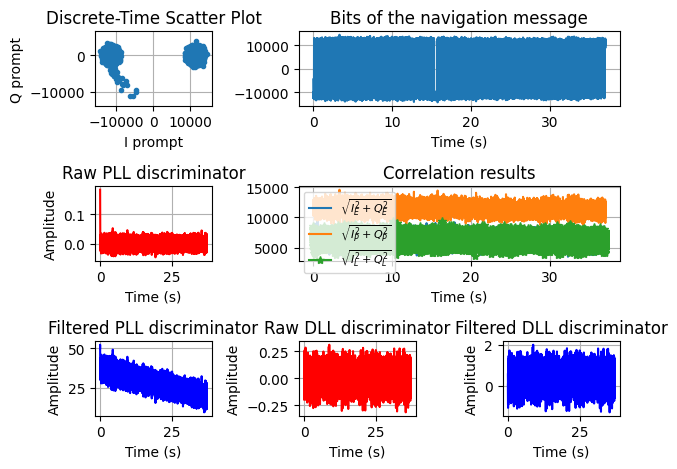

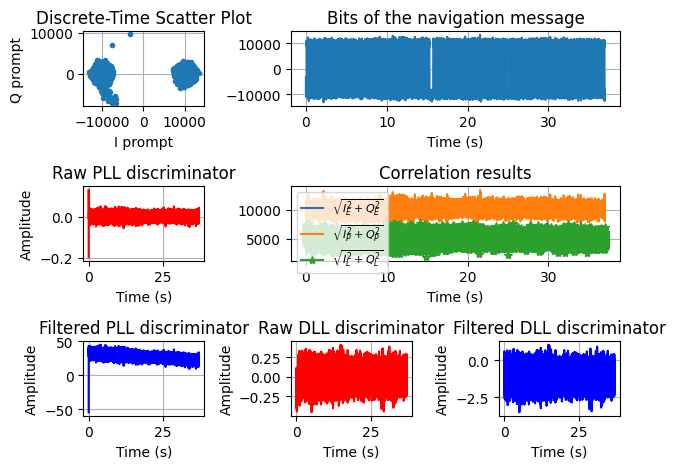

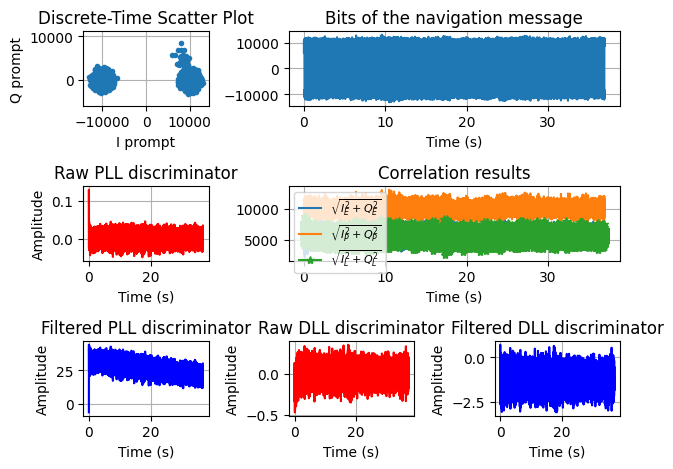

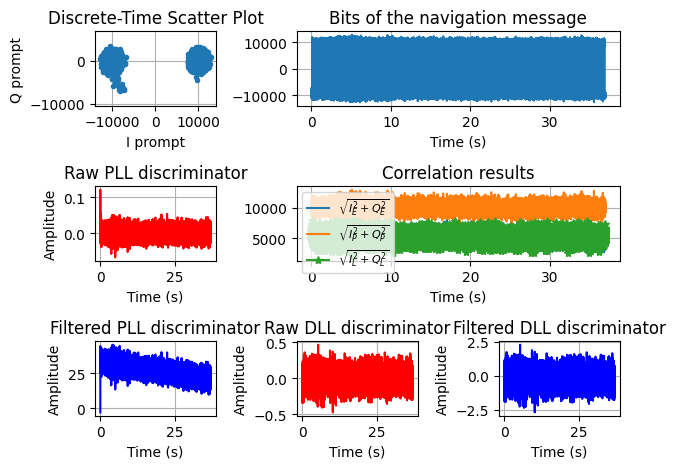

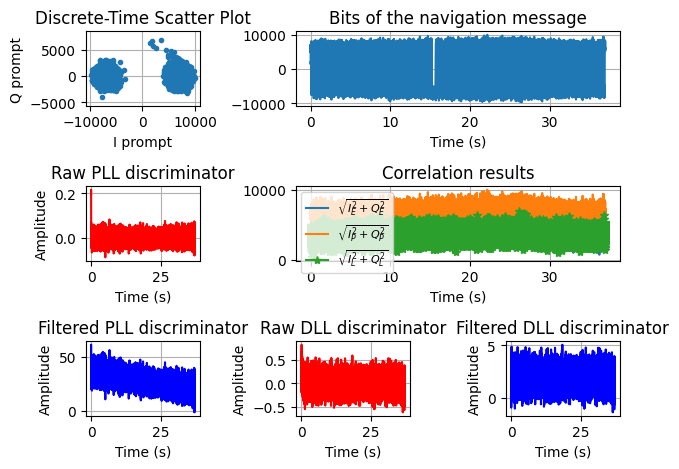

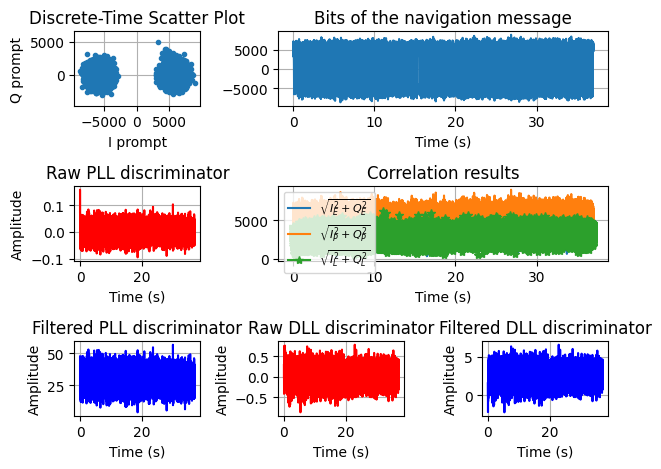

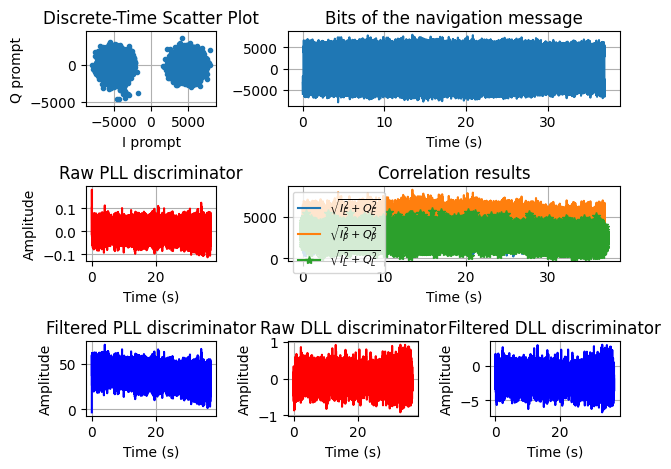

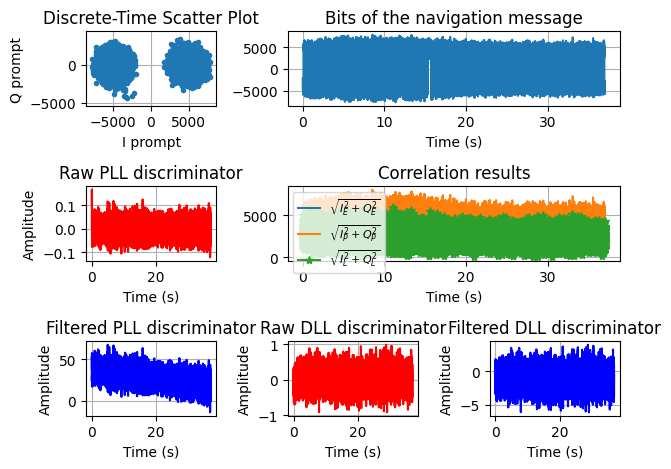

In [15]:
# === For all listed channels ==============================================
for channelNr in channelList:
    # Select (or create) and clear the figure ================================
    # # The number 200 is added just for more convenient handling of the open
    # # figure windows, when many figures are closed and reopened.
    # # Figures drawn or opened by the user, will not be "overwritten" by
    # # this function.
    f = plt.figure(channelNr + 200)
    f.set_label('Channel ' + str(channelNr) + ' (PRN ' + str(trackResults[channelNr].PRN) + ') results')
    # Draw axes ==============================================================
    # Row 1
    spec = gs.GridSpec(3, 3)
    h11 = plt.subplot(spec[0, 0])
    h12 = plt.subplot(spec[0, 1:])
    h21 = plt.subplot(spec[1, 0])
    h22 = plt.subplot(spec[1, 1:])
    h31 = plt.subplot(spec[2, 0])
    h32 = plt.subplot(spec[2, 1])
    h33 = plt.subplot(spec[2, 2])
    # Plot all figures =======================================================
    timeAxisInSeconds = np.arange(settings.msToProcess) / 1000.0

    h11.plot(trackResults[channelNr].I_P, trackResults[channelNr].Q_P, '.')
    h11.grid()
    h11.axis('equal')
    h11.set(title='Discrete-Time Scatter Plot', xlabel='I prompt', ylabel='Q prompt')

    h12.plot(timeAxisInSeconds, trackResults[channelNr].I_P)
    h12.grid()
    h12.set(title='Bits of the navigation message', xlabel='Time (s)')
    h12.axis('tight')

    h21.plot(timeAxisInSeconds, trackResults[channelNr].pllDiscr, 'r')
    h21.grid()
    h21.axis('tight')
    h21.set(xlabel='Time (s)', ylabel='Amplitude', title='Raw PLL discriminator')

    h22.plot(timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_E ** 2 + trackResults[channelNr].Q_E ** 2).T,
             timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_P ** 2 + trackResults[channelNr].Q_P ** 2).T,
             timeAxisInSeconds,
             np.sqrt(trackResults[channelNr].I_L ** 2 + trackResults[channelNr].Q_L ** 2).T, '-*')
    h22.grid()
    h22.set(title='Correlation results', xlabel='Time (s)')
    h22.axis('tight')
    h22.legend(['$\sqrt{I_{E}^2 + Q_{E}^2}$', '$\sqrt{I_{P}^2 + Q_{P}^2}$', '$\sqrt{I_{L}^2 + Q_{L}^2}$'],
           fontsize=8, loc='upper left')  # Ajuste a posição da legenda dentro do gráfico
    
    h31.plot(timeAxisInSeconds, trackResults[channelNr].pllDiscrFilt, 'b')
    h31.grid()
    h31.axis('tight')
    h31.set(xlabel='Time (s)', ylabel='Amplitude', title='Filtered PLL discriminator')

    h32.plot(timeAxisInSeconds, trackResults[channelNr].dllDiscr, 'r')
    h32.grid()
    h32.axis('tight')
    h32.set(xlabel='Time (s)', ylabel='Amplitude', title='Raw DLL discriminator')

    h33.plot(timeAxisInSeconds, trackResults[channelNr].dllDiscrFilt, 'b')
    h33.grid()
    h33.axis('tight')
    h33.set(xlabel='Time (s)', ylabel='Amplitude', title='Filtered DLL discriminator')

    f.tight_layout()
    f.show()


In [ ]:
navResults = postNavigation.NavigationResult(trackResults)
navResults.postNavigate()

In [27]:
trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)

In [ ]:
trackResults = trackResults._results

class NavigationResult(Result):
    def __init__(self, trackResult):
        self._results = trackResult.results
        self._channels = trackResult.channels
        self._settings = trackResult.settings
        self._solutions = None
        self._eph = None

In [ ]:
print('   Processing is complete for this data block')
# Plot all results ===================================================
print('   Plotting results...')
# TODO turn off tracking plots for now

In [37]:
# Initialize tracking variables ==========================================
codePeriods = settings.msToProcess
# --- DLL variables --------------------------------------------------------
# Define early-late offset (in chips)
earlyLateSpc = settings.dllCorrelatorSpacing
# Summation interval
PDIcode = 0.001
# Calculate filter coefficient values
tau1code, tau2code = settings.calcLoopCoef(settings.dllNoiseBandwidth, settings.dllDampingRatio, 1.0)

In [38]:
tau1code

0.06984693877551021

In [ ]:
if not settings.plotTracking:
    trackResults.plot()
    navResults.plot()
    print('Post processing of the signal is over.')

C:\Users\jessi\AppData\Local\Temp\ipykernel_15128\3364129192.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


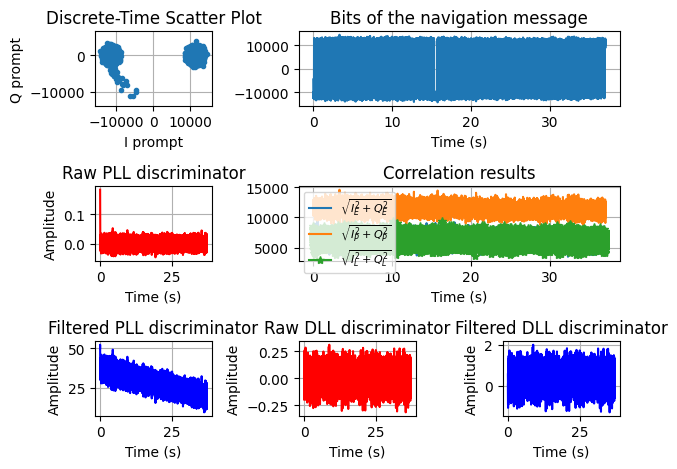

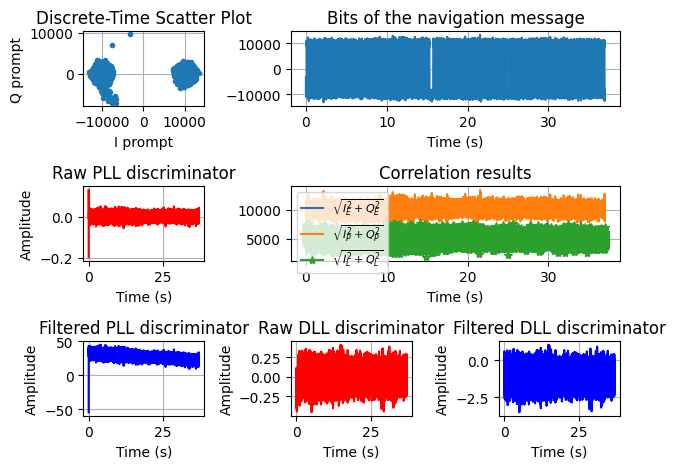

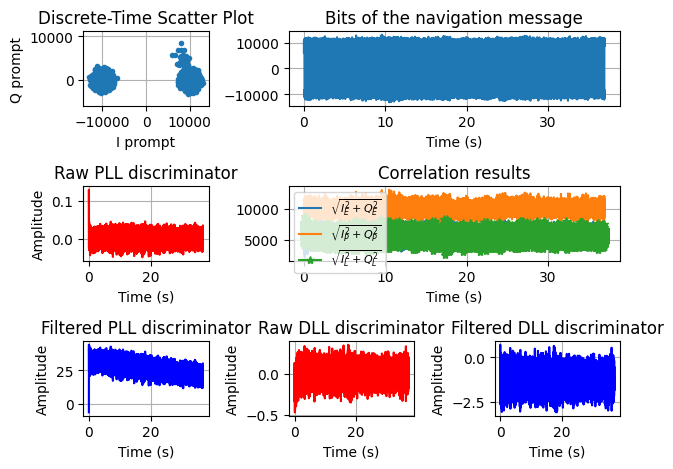

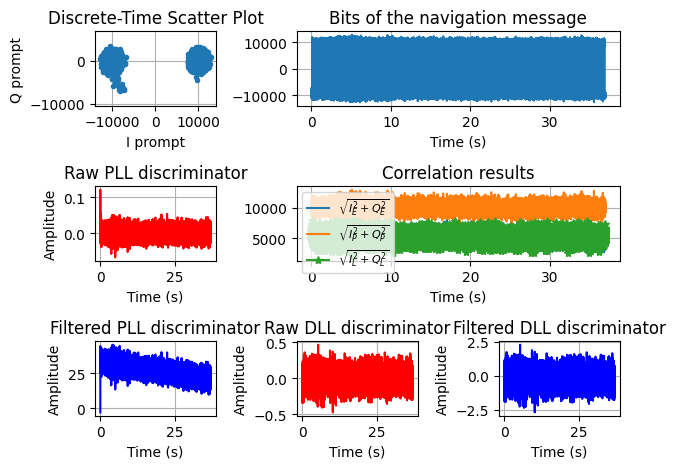

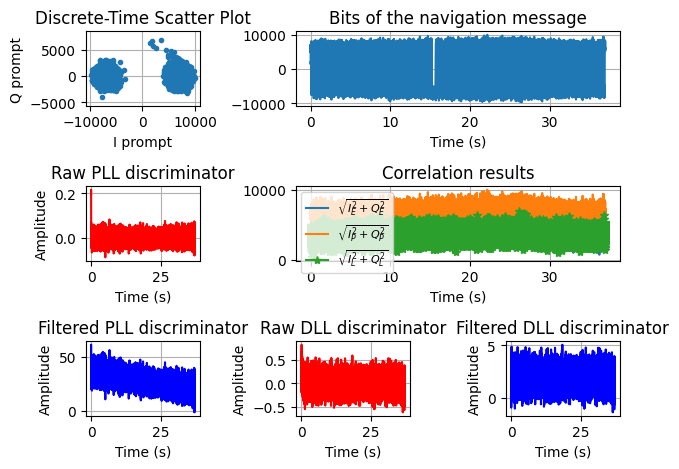

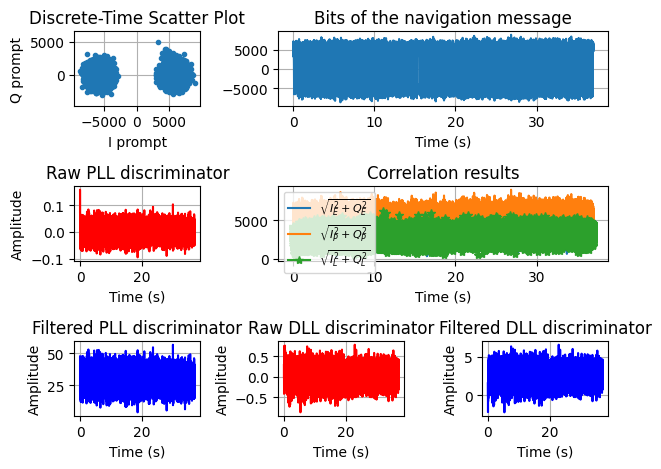

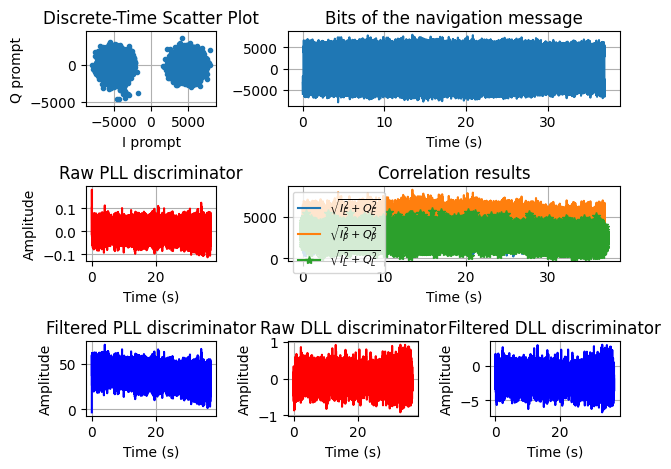

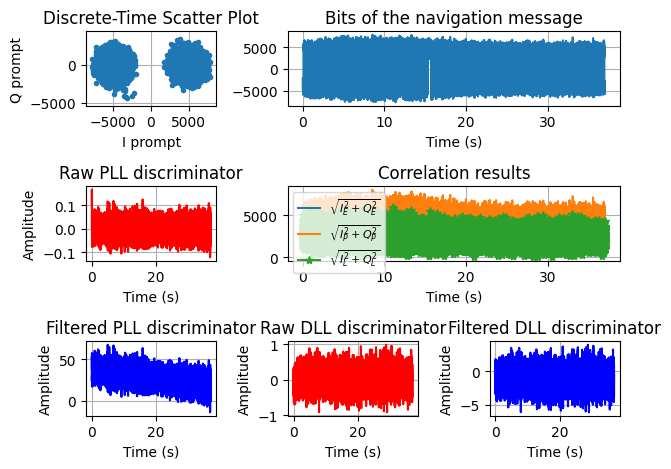

In [ ]:

        # Performs code and carrier tracking for all channels.

        # [trackResults, channel] = tracking(fid, channel, settings)

        #   Inputs:
        #       fid             - file identifier of the signal record.
        #       channel         - PRN, carrier frequencies and code phases of all
        #                       satellites to be tracked (prepared by preRum.m from
        #                       acquisition results).
        #       settings        - receiver settings.
        #   Outputs:
        #       trackResults    - tracking results (structure array). Contains
        #                       in-phase prompt outputs and absolute starting
        #                       positions of spreading codes, together with other
        #                       observation data from the tracking loops. All are
        #                       saved every millisecond.

        # Initialize tracking variables ==========================================


In [29]:
codePeriods = settings.msToProcess
# --- DLL variables --------------------------------------------------------
        # # Define early-late offset (in chips)
        # earlyLateSpc = settings.dllCorrelatorSpacing

        # # Summation interval
        # PDIcode = 0.001

        # # Calculate filter coefficient values
        # tau1code, tau2code = settings.calcLoopCoef(settings.dllNoiseBandwidth, settings.dllDampingRatio, 1.0)

        # # --- PLL variables --------------------------------------------------------
        # # Summation interval
        # PDIcarr = 0.001

        # # Calculate filter coefficient values
        # tau1carr, tau2carr = settings.calcLoopCoef(settings.pllNoiseBandwidth, settings.pllDampingRatio, 0.25)

        # #     hwb=waitbar(0,'Tracking...')

        # # Initialize a temporary list of records
        # rec = []
        # # Start processing channels ==============================================
        # for channelNr in range(settings.numberOfChannels):
        #     #msToProcess = np.long(settings.msToProcess)
        #     msToProcess = np.int64(settings.msToProcess)
        #     # Initialize fields for record(structured) array of tracked results
        #     status = '-'

        #     # The absolute sample in the record of the C/A code start:
        #     absoluteSample = np.zeros(msToProcess)

        #     # Freq of the C/A code:
        #     codeFreq_ = np.Inf * np.ones(msToProcess)

        #     # Frequency of the tracked carrier wave:
        #     carrFreq_ = np.Inf * np.ones(msToProcess)

        #     # Outputs from the correlators (In-phase):
        #     I_P_ = np.zeros(msToProcess)

        #     I_E_ = np.zeros(msToProcess)

        #     I_L_ = np.zeros(msToProcess)

        #     # Outputs from the correlators (Quadrature-phase):
        #     Q_E_ = np.zeros(msToProcess)

        #     Q_P_ = np.zeros(msToProcess)

        #     Q_L_ = np.zeros(msToProcess)

        #     # Loop discriminators
        #     dllDiscr = np.Inf * np.ones(msToProcess)

        #     dllDiscrFilt = np.Inf * np.ones(msToProcess)

        #     pllDiscr = np.Inf * np.ones(msToProcess)

        #     pllDiscrFilt = np.Inf * np.ones(msToProcess)

        #     PRN = 0

        #     # Only process if PRN is non zero (acquisition was successful)
        #     if channel[channelNr].PRN != 0:
        #         # Save additional information - each channel's tracked PRN
        #         PRN = channel[channelNr].PRN

        #         # signal processing at any point in the data record (e.g. for long
        #         # records). In addition skip through that data file to start at the
        #         # appropriate sample (corresponding to code phase). Assumes sample
        #         # type is schar (or 1 byte per sample)
        #         #fid.seek(settings.skipNumberOfBytes + channel[channelNr].codePhase, 0)
        #         fid.seek(int(settings.skipNumberOfBytes + channel[channelNr].codePhase), 0)
        #         # Here PRN is the actual satellite ID instead of the 0-based index
        #         caCode = settings.generateCAcode(channel[channelNr].PRN - 1)

        #         caCode = np.r_[caCode[-1], caCode, caCode[0]]

        #         # define initial code frequency basis of NCO
        #         codeFreq = settings.codeFreqBasis

        #         remCodePhase = 0.0

        #         carrFreq = channel[channelNr].acquiredFreq

        #         carrFreqBasis = channel[channelNr].acquiredFreq

        #         remCarrPhase = 0.0

        #         oldCodeNco = 0.0

        #         oldCodeError = 0.0

        #         oldCarrNco = 0.0

        #         oldCarrError = 0.0

        #         #for loopCnt in range(np.long(codePeriods)):
        #         for loopCnt in range(int(codePeriods)):  # Substitua np.long() por int()
        #             # GUI update -------------------------------------------------------------
        #             # The GUI is updated every 50ms. This way Matlab GUI is still
        #             # responsive enough. At the same time Matlab is not occupied
        #             # all the time with GUI task.
        #             if loopCnt % 50 == 0:
        #                 try:
        #                     print('Tracking: Ch %d' % (channelNr + 1) + ' of %d' % settings.numberOfChannels + \
        #                           '; PRN#%02d' % channel[channelNr].PRN + \
        #                           '; Completed %d' % loopCnt + ' of %d' % codePeriods + ' msec')
        #                 finally:
        #                     pass
        #             # Read next block of data ------------------------------------------------
        #             # Find the size of a "block" or code period in whole samples
        #             # Update the phasestep based on code freq (variable) and
        #             # sampling frequency (fixed)
        #             codePhaseStep = codeFreq / settings.samplingFreq

        #             blksize = np.ceil((settings.codeLength - remCodePhase) / codePhaseStep)
        #             # blksize = np.long(blksize)
        #             blksize = int(blksize)


        #             # interaction
        #             rawSignal = np.fromfile(fid, settings.dataType, blksize)
        #             samplesRead = len(rawSignal)

        #             # If did not read in enough samples, then could be out of
        #             # data - better exit
        #             if samplesRead != blksize:
        #                 print('Not able to read the specified number of samples for tracking, exiting!')
        #                 fid.close()
        #                 trackResults = None
        #                 return trackResults
        #             # Set up all the code phase tracking information -------------------------
        #             # Define index into early code vector
        #             tcode = np.linspace(remCodePhase - earlyLateSpc,
        #                                 blksize * codePhaseStep + remCodePhase - earlyLateSpc,
        #                                 blksize, endpoint=False)

        #             tcode2 = np.ceil(tcode)

        #             earlyCode = caCode[np.longlong(tcode2)]

        #             tcode = np.linspace(remCodePhase + earlyLateSpc,
        #                                 blksize * codePhaseStep + remCodePhase + earlyLateSpc,
        #                                 blksize, endpoint=False)

        #             tcode2 = np.ceil(tcode)

        #             lateCode = caCode[np.longlong(tcode2)]

        #             tcode = np.linspace(remCodePhase,
        #                                 blksize * codePhaseStep + remCodePhase,
        #                                 blksize, endpoint=False)

        #             tcode2 = np.ceil(tcode)

        #             promptCode = caCode[np.longlong(tcode2)]

        #             remCodePhase = tcode[blksize - 1] + codePhaseStep - 1023.0

        #             # Generate the carrier frequency to mix the signal to baseband -----------
        #             time = np.arange(0, blksize + 1) / settings.samplingFreq

        #             trigarg = carrFreq * 2.0 * np.pi * time + remCarrPhase

        #             remCarrPhase = trigarg[blksize] % (2 * np.pi)

        #             carrCos = np.cos(trigarg[0:blksize])

        #             carrSin = np.sin(trigarg[0:blksize])

        #             # Generate the six standard accumulated values ---------------------------
        #             # First mix to baseband
        #             qBasebandSignal = carrCos * rawSignal

        #             iBasebandSignal = carrSin * rawSignal

        #             I_E = (earlyCode * iBasebandSignal).sum()

        #             Q_E = (earlyCode * qBasebandSignal).sum()

        #             I_P = (promptCode * iBasebandSignal).sum()

        #             Q_P = (promptCode * qBasebandSignal).sum()

        #             I_L = (lateCode * iBasebandSignal).sum()

        #             Q_L = (lateCode * qBasebandSignal).sum()

        #             # Find PLL error and update carrier NCO ----------------------------------
        #             # Implement carrier loop discriminator (phase detector)
        #             carrError = np.arctan(Q_P / I_P) / 2.0 / np.pi

        #             carrNco = oldCarrNco + \
        #                       tau2carr / tau1carr * (carrError - oldCarrError) + \
        #                       carrError * (PDIcarr / tau1carr)

        #             oldCarrNco = carrNco

        #             oldCarrError = carrError

        #             carrFreq = carrFreqBasis + carrNco

        #             carrFreq_[loopCnt] = carrFreq

        #             # Find DLL error and update code NCO -------------------------------------
        #             codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) / (
        #                     np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))

        #             codeNco = oldCodeNco + \
        #                       tau2code / tau1code * (codeError - oldCodeError) + \
        #                       codeError * (PDIcode / tau1code)

        #             oldCodeNco = codeNco

        #             oldCodeError = codeError

        #             codeFreq = settings.codeFreqBasis - codeNco

        #             codeFreq_[loopCnt] = codeFreq

        #             # Record various measures to show in postprocessing ----------------------
        #             # Record sample number (based on 8bit samples)
        #             absoluteSample[loopCnt] = fid.tell()

        #             dllDiscr[loopCnt] = codeError

        #             dllDiscrFilt[loopCnt] = codeNco

        #             pllDiscr[loopCnt] = carrError

        #             pllDiscrFilt[loopCnt] = carrNco

        #             I_E_[loopCnt] = I_E

        #             I_P_[loopCnt] = I_P

        #             I_L_[loopCnt] = I_L

        #             Q_E_[loopCnt] = Q_E

        #             Q_P_[loopCnt] = Q_P

        #             Q_L_[loopCnt] = Q_L

        #         # If we got so far, this means that the tracking was successful
        #         # Now we only copy status, but it can be update by a lock detector
        #         # if implemented
        #         status = channel[channelNr].status
        #         rec.append((status, absoluteSample, codeFreq_, carrFreq_,
        #                     I_P_, I_E_, I_L_, Q_E_, Q_P_, Q_L_,
        #                     dllDiscr, dllDiscrFilt, pllDiscr, pllDiscrFilt, PRN))

        # trackResults = np.rec.fromrecords(rec,
        #                                   dtype=[('status', 'S1'), ('absoluteSample', 'object'), ('codeFreq', 'object'),
        #                                          ('carrFreq', 'object'), ('I_P', 'object'), ('I_E', 'object'),
        #                                          ('I_L', 'object'),
        #                                          ('Q_E', 'object'), ('Q_P', 'object'), ('Q_L', 'object'),
        #                                          ('dllDiscr', 'object'),
        #                                          ('dllDiscrFilt', 'object'), ('pllDiscr', 'object'),
        #                                          ('pllDiscrFilt', 'object'),
        #                                          ('PRN', 'int64')])
        # self._results = trackResults
        # return

   Tracking started at 08:20:38


AttributeError: recarray has no attribute channels

In [ ]:
try:
    with open(fileNameStr, 'rb') as fid:
        # If success, then process the data
        # Move the starting point of processing. Can be used to start the
        # signal processing at any point in the data record (e.g. good for long
        # records or for signal processing in blocks).
        fid.seek(settings.skipNumberOfBytes, 0)
        # Acquisition ============================================================
        # Do acquisition if it is not disabled in settings or if the variable acqResults does not exist.
        if not settings.skipAcquisition:  # or 'acqResults' not in globals():
            # Find number of samples per spreading code
            samplesPerCode = settings.samplesPerCode
            # frequency estimation
            data = np.fromfile(fid, settings.dataType, 11 * samplesPerCode) # type: ignore
            print('   Acquiring satellites...')
            acqResults = acquisition.AcquisitionResult(settings)
            acqResults.acquire(data)
            # acqResults.plot()
        # Initialize channels and prepare for the run ============================
        # Start further processing only if a GNSS signal was acquired (the
        # field FREQUENCY will be set to 0 for all not acquired signals)
        if np.any(acqResults.carrFreq): # type: ignore
            acqResults.preRun()
            acqResults.showChannelStatus()
        else:
            # No satellites to track, exit
            print('No GNSS signals detected, signal processing finished.')
            trackResults = None

        # Track the signal =======================================================
        startTime = datetime.datetime.now()
        print('   Tracking started at %s' % startTime.strftime('%X'))
        trackResults = tracking.TrackingResult(acqResults)
        try:
            # trackResults.results = np.load('trackingResults_python.npy')
            trackResults.results = np.load('trackingResults_python.npy', allow_pickle=True)
        except IOError:
            trackResults.track(fid)
            np.save('trackingResults_python', trackResults.results)

        print('   Tracking is over (elapsed time %s s)' % (datetime.datetime.now() - startTime).total_seconds())
        # Auto save the acquisition & tracking results to save time.
        print('   Saving Acquisition & Tracking results to storage')
        # Calculate navigation solutions =========================================
        print('   Calculating navigation solutions...')
        navResults = postNavigation.NavigationResult(trackResults)
        navResults.postNavigate()

        print('   Processing is complete for this data block')
        # Plot all results ===================================================
        print('   Plotting results...')
        # TODO turn off tracking plots for now
        if not settings.plotTracking:
            trackResults.plot()
        navResults.plot()
        print('Post processing of the signal is over.')
except IOError as e:
    # Error while opening the data file.
    print('Unable to read file "%s": %s.' % (settings.fileName, e))


In [ ]:
if gnssStart:
    print(' ')
    settings.postProcessing()